# Challenge 7

- Buscar una base de datos de Physionet de imágenes médicas y extraer una porción de ellas (probablemente 50 imágenes de cada clase)
- Hacer una red neuronal multicapa grande para hacer la clasificación consideren usar 3 capas ocultas o más
- Luego prueban si hay overfitting, si hay, reducir la red, aplicar regularización y dropout en ese orden. Luego probar combinaciones entre ellas para mejorar el modelo. Verificar con funciones de pérdida o costo [min 20 epoc] y métrica accuracy.

In [1]:
from pydicom import dcmread
from sklearn.utils import resample
from cv2 import resize
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [4]:
IMG_HEIGHT, IMG_WIDTH = 256, 256


def imageid2np(imageids: np.ndarray, path: str, lims: np.ndarray) -> np.ndarray:
    # from pydicom import dcmread

    # Se leen las imágenes y se retornan en un np.ndarray
    images = []
    for i in tqdm(range(len(imageids))):
        # print(imageids[i])
        image_path = f'{path}/{imageids[i]}.dicom'
        ds = dcmread(image_path)
        # Se normalizan las imágenes en base a su bit depth
        bitdepth_n = 2**ds.BitsStored - 1
        image = ds.pixel_array[lims[i,1]:lims[i,3],lims[i,0]:lims[i,2]]/bitdepth_n
        try:
            image = resize(image, (IMG_WIDTH, IMG_HEIGHT))
        except:
            print(imageids[i])
            print(np.shape(image))
            break
        images.append(image)
    # return images
    return np.array(images)


def process_csv(filename: str, random_state=42, minsize=None) -> tuple:
    # from sklearn.utils import resample

    csv = pd.read_csv(filename)
    csv2 = csv[['image_id', 'lesion_type', 'xmin', 'ymin', 'xmax', 'ymax']]

    # Se elimina other lesions ya que no necesariamente tienen características en común
    csv2 = csv2[csv2['lesion_type'] != 'Other lesions']
    # Se descarta no finding ya que no tienen anotaciones de posición
    csv2 = csv2[csv2['lesion_type'] != 'No finding']

    # Se hace un balanceo de la data
    # Para el training se usan 268
    # Para el testing se usan 69
    # 69/(69+268)=20.47%
    if not minsize:
        minority_class_size = csv2['lesion_type'].value_counts().min()
    else:
        # Sin embargo, el dataset es muy grande por la cantidad de imágenes
        minority_class_size = minsize
    classes = csv2['lesion_type'].unique()
    csv2_bal = pd.DataFrame()

    for c in classes:
        df_class = csv2[csv2['lesion_type'] == c]
        df_class_resampled = resample(
            df_class,
            replace=False,
            n_samples=minority_class_size,
            random_state=random_state,
        )
        csv2_bal = pd.concat([csv2_bal, df_class_resampled])

    X_ids = csv2_bal['image_id']
    X_ids = X_ids.values

    lims = csv2_bal[['xmin', 'ymin', 'xmax', 'ymax']]
    lims = lims.values
    lims = abs(lims.astype('int'))

    y = csv2_bal['lesion_type']
    # Se usa one-hot encoding para los labels
    y = pd.get_dummies(y)
    y = y.values

    fn_split = filename.split('/')
    img_folder = f'{fn_split[0]}/{fn_split[-1][:-4]}_images'

    # X_ids=X_ids[:10]
    # y=y[:10]

    X = imageid2np(X_ids, img_folder, lims)

    # Se retornan en np.ndarray
    return X, y

In [5]:
print('train')
X_train, y_train = process_csv('data_ch7/annotations/train.csv')  # ,minsize=160)
print('test')
X_test, y_test = process_csv('data_ch7/annotations/test.csv')  # ,minsize=40)

train


  0%|                                                                                          | 0/1608 [00:00<?, ?it/s]/home/pece/patrones/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1608/1608 [16:14<00:00,  1.65it/s]


test


  0%|                                                                                           | 0/414 [00:00<?, ?it/s]/home/pece/patrones/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████| 414/414 [04:03<00:00,  1.70it/s]


In [50]:
import pickle
with open('xy.pkl', 'wb') as f:
    pickle.dump([X_train, y_train, X_test, y_test], f)

In [ ]:
import pickle
with open('xy.pkl', 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [6]:
# for i in X_train:
#     print(np.shape(i))
#     plt.figure()
#     plt.imshow(i)
# for i in X_test:print(type(i))
# print(np.max(X_train))

## Modelo

Se utilizarán 100 epochs para evaluar el aprendizaje del modelo. Esto no significa que 100 epochs es el número ideal.

In [42]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [43]:
X_train.shape

(1608, 256, 256)

In [44]:
epochs = 100

In [45]:
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,820,902 (64.17 MB)

 Trainable params: 16,820,902 (64.17 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1584 - loss: 9.1101 - val_accuracy: 0.0000e+00 - val_loss: 2.2892
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2129 - loss: 1.7884 - val_accuracy: 0.0000e+00 - val_loss: 1.8455
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2075 - loss: 1.7776 - val_accuracy: 0.0000e+00 - val_loss: 1.8739
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2165 - loss: 1.7706 - val_accuracy: 0.0000e+00 - val_loss: 1.9041
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2145 - loss: 1.7647 - val_accuracy: 0.0000e+00 - val_loss: 1.9353
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2017 - loss: 1.7585 - val_accuracy: 0.0000e+00 - val_loss: 1.9664
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2125 - loss: 1.7517 - val_accuracy: 0.0000e+00 - val_loss: 1.9980
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2231 - loss: 1.74

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5129 - loss: 4.5960
Test accuracy: 0.5193236470222473


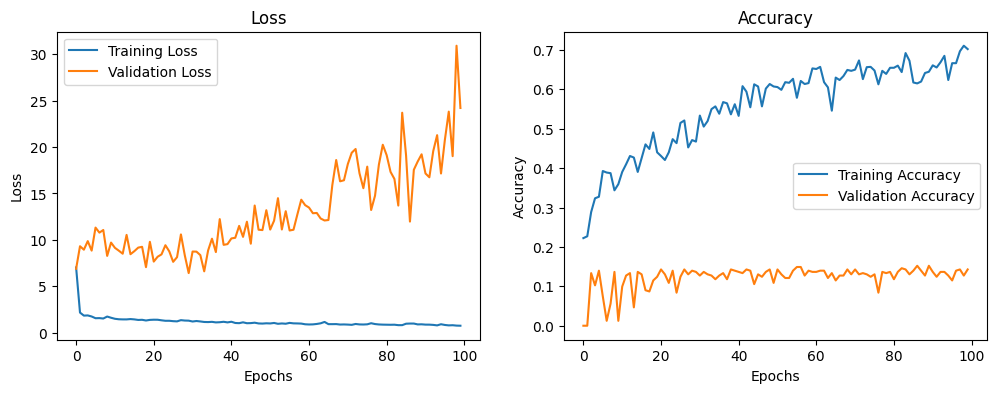

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Combatir el overfitting

### Reducir la red

In [ ]:
# Definir un modelo reducido
model_reduced = Sequential()
model_reduced.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model_reduced.add(Dense(64, activation='relu'))
model_reduced.add(Dense(32, activation='relu'))
model_reduced.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model_reduced.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_reduced.summary()

# Entrenar el modelo reducido
history_reduced = model_reduced.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

# Evaluar el modelo reducido
test_loss_reduced, test_acc_reduced = model_reduced.evaluate(X_test, y_test)
print(f'Test accuracy (reduced model): {test_acc_reduced}')


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,196,646 (16.01 MB)

 Trainable params: 4,196,646 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1989 - loss: 5.4813 - val_accuracy: 0.0000e+00 - val_loss: 4.3444
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2086 - loss: 1.7169 - val_accuracy: 0.0124 - val_loss: 5.2761
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2442 - loss: 1.7185 - val_accuracy: 0.1677 - val_loss: 1.8749
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1696 - loss: 1.7698 - val_accuracy: 0.1677 - val_loss: 1.9215
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1758 - loss: 1.7604 - val_accuracy: 0.1677 - val_loss: 1.9639
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1687 - loss: 1.7523 - val_accuracy: 0.1677 - val_loss: 2.0043
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1977 - loss: 1.7447 - val_accuracy: 0.0000e+00 - val_loss: 2.0428
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2091 - loss: 1.7378 - val_accuracy: 0

### Regularización L2

In [ ]:
# Definir un modelo con regularización L2
model_l2 = Sequential()
model_l2.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model_l2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model_l2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_l2.summary()

# Entrenar el modelo con regularización L2
history_l2 = model_l2.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

# Evaluar el modelo con regularización L2
test_loss_l2, test_acc_l2 = model_l2.evaluate(X_test, y_test)
print(f'Test accuracy (L2 regularization): {test_acc_l2}')


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,820,902 (64.17 MB)

 Trainable params: 16,820,902 (64.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2068 - loss: 13.3686 - val_accuracy: 0.0000e+00 - val_loss: 28.0017
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2232 - loss: 9.1590 - val_accuracy: 0.0000e+00 - val_loss: 16.6462
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2454 - loss: 5.0582 - val_accuracy: 0.1460 - val_loss: 11.1074
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2553 - loss: 3.8549 - val_accuracy: 0.0000e+00 - val_loss: 11.0804
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2743 - loss: 3.4486 - val_accuracy: 0.0062 - val_loss: 8.3349
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3031 - loss: 3.1145 - val_accuracy: 0.0000e+00 - val_loss: 7.2037
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2644 - loss: 3.0752 - val_accuracy: 0.0466 - val_loss: 6.7385
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2369 - loss: 2.9391 - va

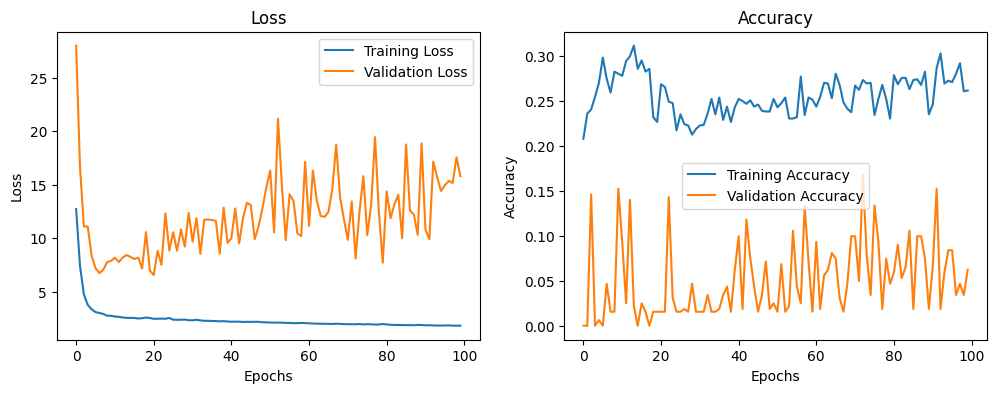

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_l2.history['loss'], label='Training Loss')
plt.plot(history_l2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_l2.history['accuracy'], label='Training Accuracy')
plt.plot(history_l2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Dropout

In [ ]:
# Definir un modelo con Dropout
model_dropout = Sequential()
model_dropout.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model_dropout.add(Dense(128, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(64, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model_dropout.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_dropout.summary()

# Entrenar el modelo con Dropout
history_dropout = model_dropout.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

# Evaluar el modelo con Dropout
test_loss_dropout, test_acc_dropout = model_dropout.evaluate(X_test, y_test)
print(f'Test accuracy (Dropout): {test_acc_dropout}')


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,399,270 (32.04 MB)

 Trainable params: 8,399,270 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.1791 - loss: 11.2783 - val_accuracy: 0.0000e+00 - val_loss: 1.8524
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2065 - loss: 1.8498 - val_accuracy: 0.0000e+00 - val_loss: 1.9732
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2117 - loss: 1.7478 - val_accuracy: 0.0000e+00 - val_loss: 2.0852
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2019 - loss: 1.7291 - val_accuracy: 0.0000e+00 - val_loss: 2.3618
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2015 - loss: 1.7915 - val_accuracy: 0.0000e+00 - val_loss: 2.3003
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1996 - loss: 1.7031 - val_accuracy: 0.0000e+00 - val_loss: 2.4061
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2112 - loss: 1.6864 - val_accuracy: 0.0000e+00 - val_loss: 2.5055
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2015 - loss: 1.6

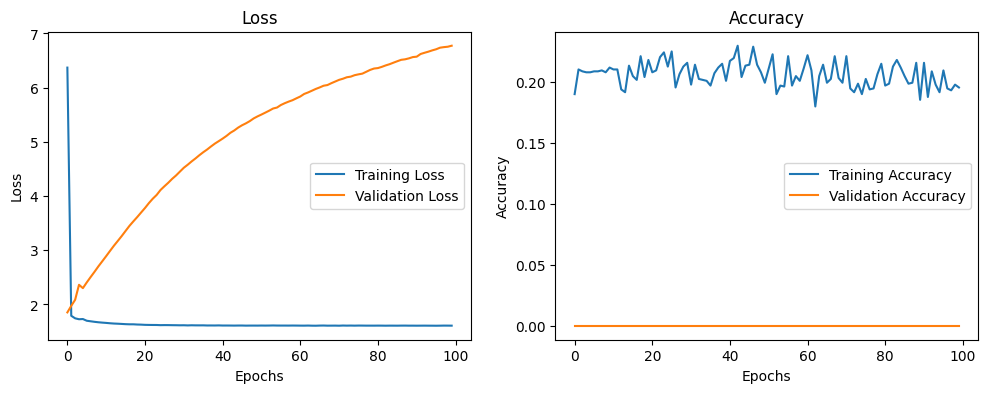

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['loss'], label='Training Loss')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dropout.history['accuracy'], label='Training Accuracy')
plt.plot(history_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Combinados

In [ ]:
# Definir un modelo con combinación de técnicas (reducción + regularización + Dropout)
model_combined = Sequential()
model_combined.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model_combined.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_combined.add(Dropout(0.5))
model_combined.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_combined.add(Dropout(0.5))
model_combined.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model_combined.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_combined.summary()

# Entrenar el modelo combinado
history_combined = model_combined.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32)

# Evaluar el modelo combinado
test_loss_combined, test_acc_combined = model_combined.evaluate(X_test, y_test)
print(f'Test accuracy (combined techniques): {test_acc_combined}')


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,196,646 (16.01 MB)

 Trainable params: 4,196,646 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.1773 - loss: 12.3968 - val_accuracy: 0.0000e+00 - val_loss: 3.6555
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2068 - loss: 3.5209 - val_accuracy: 0.0000e+00 - val_loss: 3.3665
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2175 - loss: 3.1503 - val_accuracy: 0.0000e+00 - val_loss: 3.1232
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2153 - loss: 2.9507 - val_accuracy: 0.0000e+00 - val_loss: 3.0184
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2055 - loss: 2.6966 - val_accuracy: 0.0000e+00 - val_loss: 3.0059
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2131 - loss: 2.5465 - val_accuracy: 0.0000e+00 - val_loss: 2.7701
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1815 - loss: 2.2783 - val_accuracy: 0.0000e+00 - val_loss: 2.7498
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1860 - loss: 2.

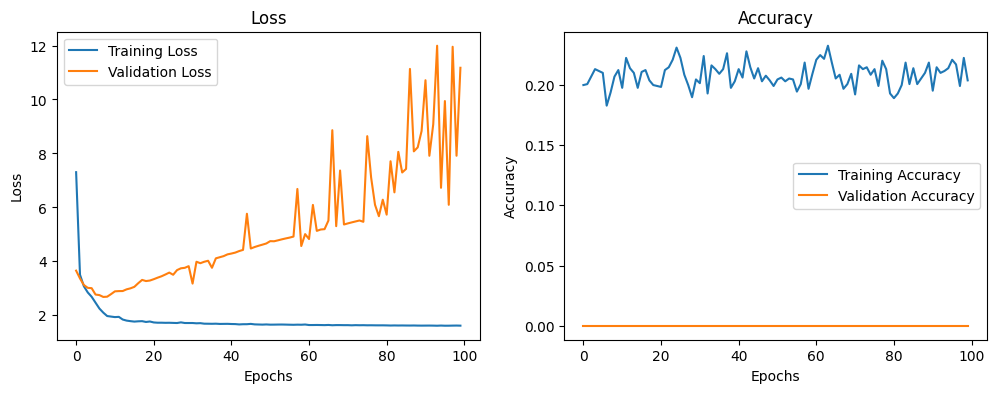

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_combined.history['accuracy'], label='Training Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Al parecer ninguna técnica ayudó realmente a reducir el overfitting. Se necesita un mejor tratamiento de las imágenes para poder mejorar el modelo, ya que actualmente estas pierden su relación de aspecto original antes de ingresar al modelo.